## Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of satellite images. We'll see the following:

* Find a time series of images at a particular point on Earth
* Stack those images together into a single array
* Compute the cloudless mosaic by taking a median
* Visualize the results

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here apply equally well to other remote-sensing datasets.

In [55]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [56]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.00b408941c4b4d9c8f0a92ea0cec72be/status


### Discover data

In this example, we define our area of interest as a GeoJSON object. It's near Redmond, Washington.

In [57]:
#Reef, including Moore Reef
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
           [145.7565490799032, -17.396699998501447],
              [147.00887273069986, -17.396699998501447],
              [147.00887273069986, -16.69828062055224],
              [145.7565490799032, -16.69828062055224],
              [145.7565490799032, -17.396699998501447]
        ]
    ],
}
bbox = rasterio.features.bounds(area_of_interest)

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [67]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2021-01-01/2021-11-11",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(len(items))

76


So these items match our search requirements, over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [68]:
selected_item = sorted(items, key=lambda item: item.properties["eo:cloud_cover"])[20]

In [69]:
for asset_key, asset in selected_item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [61]:
import json
import requests

thumbnail_asset = selected_item.assets["preview"]
signed_href = planetary_computer.sign(thumbnail_asset.href)


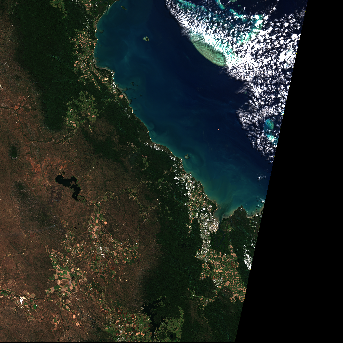

In [62]:
from PIL import Image
from urllib.request import urlopen

Image.open(urlopen(signed_href))

In [63]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [64]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B04", "B03", "B02"],  # red, green, blue
        chunksize=4096,
        resolution=100,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

<xarray.DataArray 'stackstac-685692ed2dcdc2186917ff2bfd0419fb' (time: 76, band: 3, y: 2098, x: 3098)>
dask.array<where, shape=(76, 3, 2098, 3098), dtype=float64, chunksize=(1, 1, 2098, 3098), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2021-01-23...
    id                                       (time) <U54 'S2A_MSIL2A_20210123...
  * band                                     (band) <U5 'red' 'green' 'blue'
  * x                                        (x) float64 3e+05 ... 6.097e+05
  * y                                        (y) float64 8.2e+06 ... 7.99e+06
    s2:processing_baseline                   (time) object None None ... '03.00'
    ...                                       ...
    proj:shape                               object {10980}
    title                                    (band) <U20 'Band 4 - Red - 10m'...
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32755
Attributes:
    spec:        RasterSpec(epsg=32755, bounds=(300000, 7990200, 609800, 8200...
    crs:         epsg:32755
    transform:   | 100.00, 0.00, 300000.00|\n| 0.00,-100.00, 8200000.00|\n| 0...
    resolution:  100

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [65]:
data = data.persist()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

This will be computed in parallel on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [70]:
median = data.median(dim="time").compute()

To visualize the data, we'll use xarray-spatial's `true_color` method to convert to red/green/blue values.

In [71]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

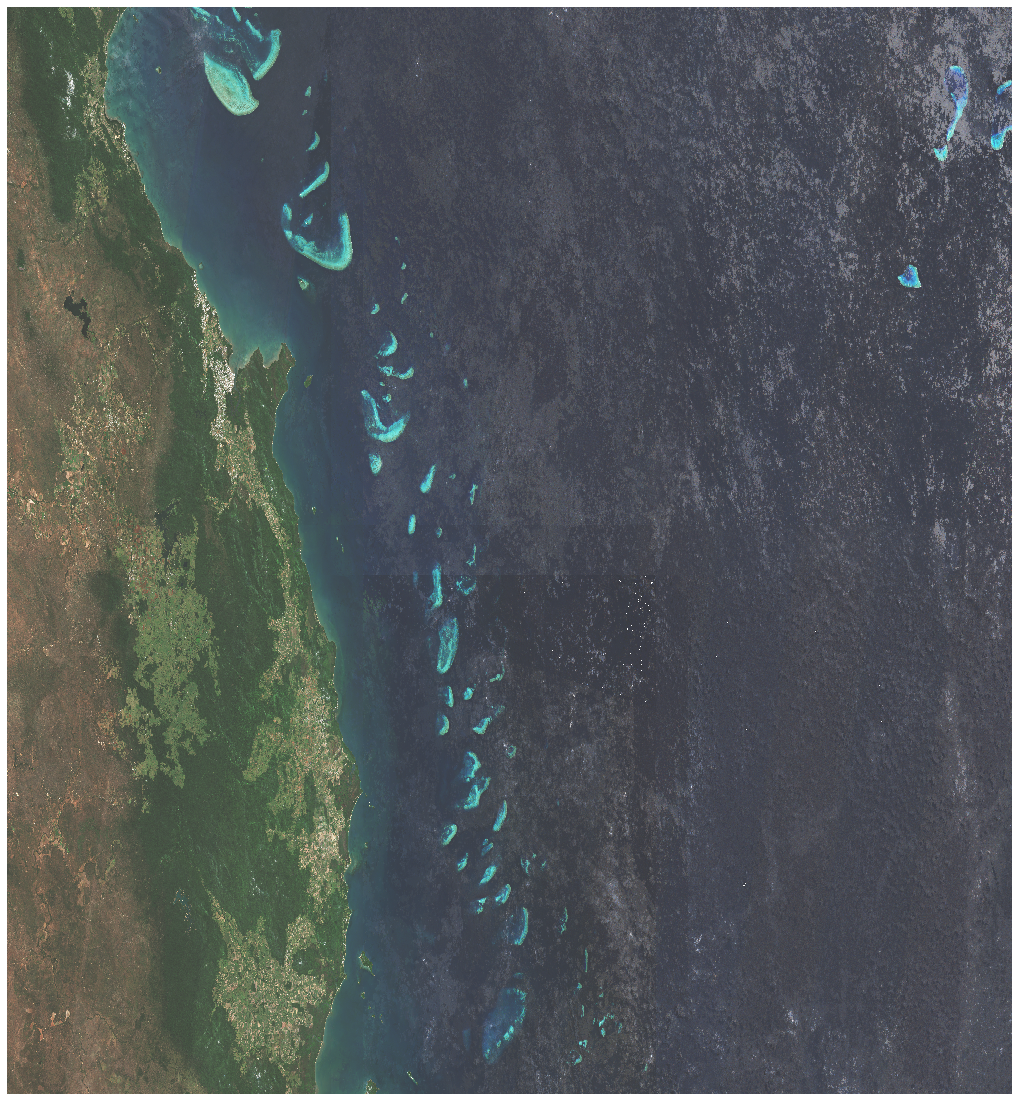

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 1

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 20))

ax.set_axis_off()
image.plot.imshow(ax=ax);

### Monthly composite

Now suppose we don't want to combine images from different parts of the year (for example, we might not want to combine images from January that often include snow with images from July). Again using standard xarray syntax, we can create set of per-month composites by grouping by month and then taking the median.

In [34]:
monthly = data.groupby("time.month").median().compute()

Let's convert each of those arrays to a true-color image and plot the results as a grid.

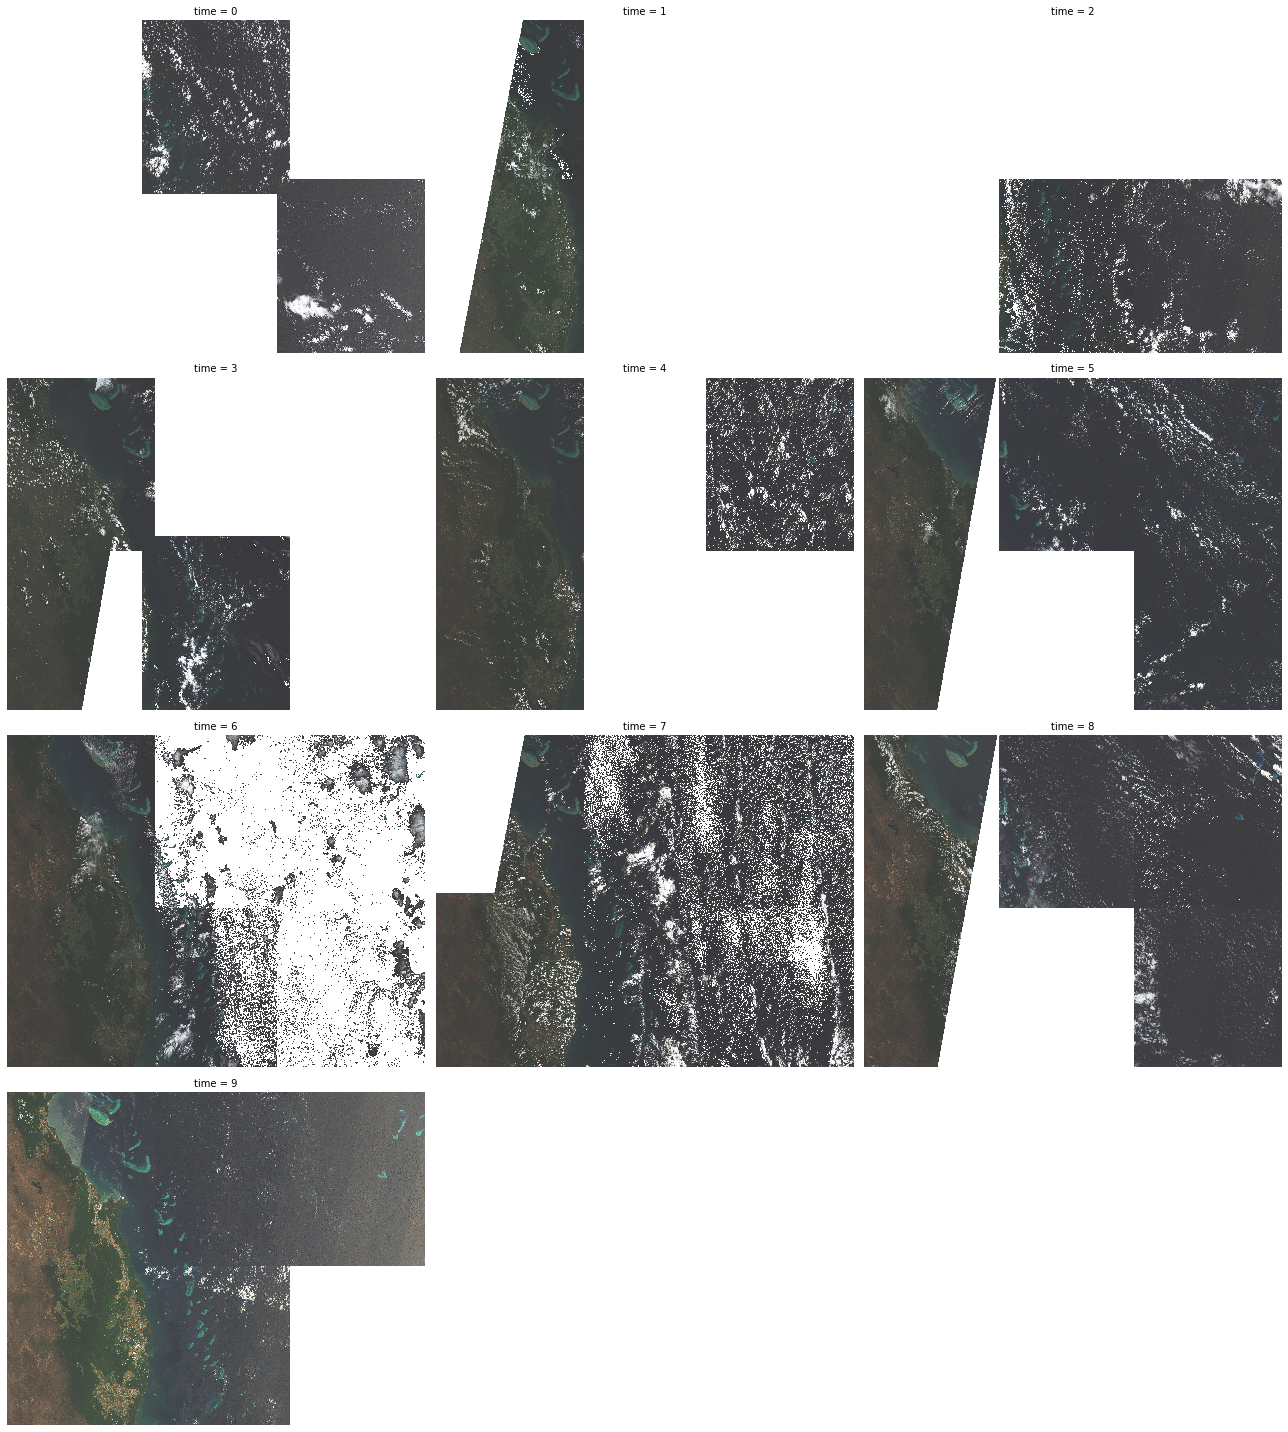

In [35]:
images = [ms.true_color(*x) for x in monthly]
images = xr.concat(images, dim="time")

g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=3, figsize=(18, 20))
for ax in g.axes.flat:
    ax.set_axis_off()

plt.tight_layout()

### Learn more

To learn more about using the the Planetary Computer's STAC API, see [Reading data from the STAC API](../quickstarts/reading-stac.ipynb). To learn more about Dask, see [Scaling with Dask](../quickstarts/scale-with-dask.ipynb).